In [1]:
import numpy as np
import pandas as pd
import random

import math

import matplotlib.pyplot as plt

from kaggle_environments import make, evaluate, utils

In [2]:
import sys
random.seed()

In [3]:
# Подсказка чтобы не забыть обозначения
#0 - rock 
#1 - paper
#2 - scissors

In [4]:
# Количество игр для каждого матча между двумя агентами
number_of_episodes = 1000

In [5]:
# Список, сопоставляющий вариант с выигрышным ему
win_options = [1, 2, 0]

In [6]:
# Простые агенты, которые всегда выбирают только заданный заранее элемент

def rock_agent(observation, configuration):
    return 0


def paper_agent(observation, configuration):
    return 1


def scissors_agent(observation, configuration):
    return 2

In [7]:
# Агент #1 - на первом шаге случайно выбирает один из вариантов и потом всегда использует его

first_random_action = None


def first_random_agent(observation, configuration):
    global first_random_action
    if observation.step == 0:
        first_random_action = random.randrange(0, configuration.signs)
    return first_random_action

In [8]:
# Агент #2 - выбирает варианты по очереди

order_action = 0


def order_agent(observation, configuration):
    global order_action
    if order_action == 2:
        order_action = 0
    else:
        order_action += 1
    return order_action

In [9]:
# Агент #3 - выбирает варианты по очереди, а потом в обратном порядке

counterorder_action = 0
counterorder_additive = 1


def counterorder_agent(observation, configuration):
    global counterorder_action
    global counterorder_additive
    if counterorder_action == 2:
        counterorder_additive = -1
    elif counterorder_action == 0:
        counterorder_additive = 1
    counterorder_action += counterorder_additive
    return counterorder_action

In [10]:
# Агент #4 - всегда выбирает варианты случайно


def always_random_agent(observation, configuration):
    return random.randrange(0, configuration.signs)

In [11]:
# Агент #5
# 1. Выбирает вариант случайно
# 2. Повторяет его
# 3. Выбирает случайно вариант из двух оставшихся
# 4. Повторяет действия 1-3

random_with_repeat_action = None
random_with_repeat_counter = 0


def random_agent_with_repeat(observation, configuration):
    global random_with_repeat_action
    global random_with_repeat_counter
    if random_with_repeat_counter == 0:
        random_with_repeat_action = random.randrange(0, configuration.signs)
        random_with_repeat_counter += 1
    else:
        if random_with_repeat_counter == 2:
            list_for_choice = [i for i in range(0, configuration.signs) if i != random_with_repeat_action]
            random_with_repeat_action = random.choice(list_for_choice)
            random_with_repeat_counter = 0
        else:
            random_with_repeat_counter += 1
    return random_with_repeat_action

In [12]:
# Агент #6 - выбирает случайно вариант и дальше не использует его, выбирая случайно из двух оставшихся

choosen_action = None
actions_list = []


def random_agent_with_exclusion(observation, configuration):
    global choosen_action
    global actions_list
    if observation.step == 0:
        choosen_action = random.randrange(0, configuration.signs)
    actions_list = [i for i in range(0, configuration.signs) if i != choosen_action]
    return random.choice(actions_list)

In [13]:
# Агент #7 - берет последний вариант соперника и выбирает выигрышный к нему


def counter_agent(observation, configuration):
    if observation.step == 0:
        return random.randrange(0, configuration.signs)
    else:
        return win_options[observation.lastOpponentAction]

In [14]:
# Агент #8 - запоминает 2 последних варианта соперника и выбирает случайно из выигрышных к ним

counter_pre_pre_action = None


def agent_counter_memorized_2(observation, configuration):
    global counter_pre_pre_action
    res_action = 0
    if observation.step == 0:
        res_action = random.randrange(0, configuration.signs)
    else:
        if counter_pre_pre_action is None:
            res_action = random.randrange(0, configuration.signs)
        else:
            res_action = random.choice([win_options[counter_pre_pre_action], win_options[observation.lastOpponentAction]])
        counter_pre_pre_action = observation.lastOpponentAction
    return res_action 

In [15]:
# Агент #9 - берет последний вариант соперника и выбирает случайно из двух других


def random_counter_agent(observation, configuration):
    if observation.step == 0:
        return random.randrange(0, configuration.signs)
    else:
        return random.choice([i for i in range(0, configuration.signs) if i != observation.lastOpponentAction])

In [16]:
# Агент #10 - запоминает последние 2 варианта соперника и выбирает третий или случайно из двух оставшихся

random_pre_pre_action = None


def agent_random_memorized_2(observation, configuration):
    global random_pre_pre_action
    res_action = 0
    if observation.step == 0:
        res_action = random.randrange(0, configuration.signs)
    else:
        if random_pre_pre_action is None:
            res_action = random.randrange(0, configuration.signs)
        else:
            list_for_choice = [i for i in range(0, configuration.signs) if i != random_pre_pre_action and i != observation.lastOpponentAction]
            res_action = random.choice(list_for_choice)
        random_pre_pre_action = observation.lastOpponentAction
    return res_action

In [34]:
# Агент #11
# - запоминает последние 10 вариантов соперника или выбирает случайный при их отсутствии
# - присваивает каждому из вариантов вес в соответсвии с частотой появления
# - выбирает выигрышный вариант для варианта с максимальным весом

from collections import Counter


last_10_options = []


def calc_actions_weights(actions_data):
    options_count = Counter(actions_data)
    data_size = len(actions_data)
    return [options_count[0]/data_size, options_count[1]/data_size, options_count[2]/data_size]


def agent_last_10_weights(observation, configuration):
    global last_10_options
    if observation.step == 0:
        current_action = random.randrange(0, configuration.signs)
    else:
        if len(last_10_options) < 10:
            current_action = random.randrange(0, configuration.signs)
            last_10_options.append(observation.lastOpponentAction)
        else:
            actions_weights = calc_actions_weights(last_10_options)
            max_weight = max(actions_weights)
            current_action = win_options[actions_weights.index(max_weight)]
            last_10_options = last_10_options[1:]
            last_10_options.append(observation.lastOpponentAction)
    return current_action


In [35]:
# Агент #12
# 1. Выбирает случайно вариант
# 2. Выдает его n_value раз
# 3. Повторяет шаги 1 и 2

n_value = 10

n_times_counter = 1
n_times_action = None


def agent_random_n_times(observation, configuration):
    global n_times_action
    global n_times_counter
    global n_value
    if observation.step == 0:
        n_times_action = random.randrange(0, configuration.signs)
    else:
        if n_times_counter == n_value:
            n_times_action = random.randrange(0, configuration.signs)
            n_times_counter = 1
        else:
            n_times_counter += 1
    return n_times_action

In [36]:
# Агент #13
# 1. Выбирает случайно вариант
# 2. Выдает его случайное количество раз, но не больше n_max_value
# 3. Повторяет шаги 1 и 2

n_max_value = 10
n_2_value = 1

n_times_2_counter = 1
n_times_2_action = None


def agent_random_n_2_times(observation, configuration):
    global n_times_2_action
    global n_times_2_counter
    global n_max_value
    global n_2_value
    if observation.step == 0:
        n_times_2_action = random.randrange(0, configuration.signs)
        n_2_value = random.randrange(1, n_max_value)
    else:
        if n_times_2_counter == n_2_value:
            n_times_2_action = random.randrange(0, configuration.signs)
            n_2_value = random.randrange(1, n_max_value)
            n_times_2_counter = 1
        else:
            n_times_2_counter += 1
    return n_times_2_action

In [37]:
all_agents_dictionary = {
    'first_random_agent': first_random_agent,  # 1
    'order_agent': order_agent,  # 2
    'counterorder_agent': counterorder_agent,  # 3
    'always_random_agent': always_random_agent,  # 4
    'random_agent_with_repeat': random_agent_with_repeat,  # 5
    'random_agent_with_exclusion': random_agent_with_exclusion,  # 6
    'counter_agent': counter_agent,  # 7
    'agent_counter_memorized_2': agent_counter_memorized_2,  # 8
    'random_counter_agent': random_counter_agent,  # 9
    'agent_random_memorized_2': agent_random_memorized_2,  # 10
    'agent_last_10_weights': agent_last_10_weights,  # 11
    'agent_random_n_times': agent_random_n_times,  # 12
    'agent_random_n_2_times': agent_random_n_2_times  # 13
}

In [38]:
# Функция, моделирующая турнир по следующим првилам:
# 1. Турнир проводится в виде попарных игр между агентами количеством number_of_episodes
# 2. Турнир включает игру агента с самим собой
# 3. Для определения победы установлен порог, равный 5
# 4. В случае победы агент получает 1 балл
# 5. В случае ничьей оба агента получают по 0.5 балла


def start_tournament(agents):
    results = {agent: 0.0 for agent in agents}
    for agent_1 in agents:
        for agent_2 in agents:
            game_result = evaluate("rps", [agents[agent_1], agents[agent_2]], configuration={"episodeSteps": number_of_episodes, "tieRewardThreshold": 5})
            if game_result[0][0] == 0.0:
                results[agent_1] += 0.5
                results[agent_2] += 0.5
            if game_result[0][0] > 0.0:
                results[agent_1] += 1.0
            if game_result[0][0] < 0.0:
                results[agent_2] += 1.0
    return results

In [39]:
# Запускаем турнир со словарем агентов и подготавливаем результаты для анализа


tournament_result = start_tournament(all_agents_dictionary)
data_for_graph = pd.DataFrame(tournament_result.items(), columns=['Agent', 'Scores'])
data_for_graph

,Agent,Scores
0,first_random_agent,8.5
1,order_agent,13.5
2,counterorder_agent,11.5
3,always_random_agent,12.0
4,random_agent_with_repeat,17.0
5,random_agent_with_exclusion,9.5
6,counter_agent,18.0
7,agent_counter_memorized_2,16.5
8,random_counter_agent,14.0
9,agent_random_memorized_2,12.5


<BarContainer object of 13 artists>

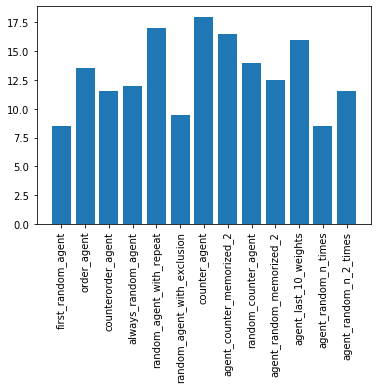

In [40]:
plt.xticks(rotation=90)  # Поворачиваем надписи на оси х
plt.bar(data_for_graph["Agent"], data_for_graph["Scores"])

In [ ]:
# По результатам проведенных расчетов набольшее количество баллов - 18 набрал counter_agent
# counter_agent - (берет последний вариант соперника и выбирает выигрышный к нему)
# Наименьшее количество баллов - 8.5 набрали агенты first_random_agent и agent_random_n_times
# first_random_agent - (на первом шаге случайно выбирает один из вариантов и потом всегда использует его)
# agent_random_n_times - (Выбирает случайно вариант, выдает его n_value раз и повторяет эти шаги)